<P> <img src="https://i.ibb.co/gyNf19D/nhslogo.png" alt="nhslogo" border="0" width="100" align="right"><font size="6"><b> CS5131</b> Introduction to Artificial Intelligence - Assignment 2</font>

# Utilising and Optimising Genetic Algorithms to Play Mastermind

In this assignment, we were tasked with 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-1:-Mastermind" data-toc-modified-id="Task-1:-Mastermind-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task 1: Mastermind</a></span></li><li><span><a href="#Task-2:-Genetic-Algorithm" data-toc-modified-id="Task-2:-Genetic-Algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task 2: Genetic Algorithm</a></span></li><li><span><a href="#Task-3:-Optimization" data-toc-modified-id="Task-3:-Optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Task 3: Optimization</a></span><ul class="toc-item"><li><span><a href="#Data-Collection-and-Retrieval" data-toc-modified-id="Data-Collection-and-Retrieval-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Collection and Retrieval</a></span></li><li><span><a href="#Q1:-Comparison-of-Selection,-Crossover-and-Mutation-Rates-(TODO)" data-toc-modified-id="Q1:-Comparison-of-Selection,-Crossover-and-Mutation-Rates-(TODO)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Q1: Comparison of Selection, Crossover and Mutation Rates (TODO)</a></span></li><li><span><a href="#Q2:-What-would-be-an-ideal-crossover-and-mutation-rate?" data-toc-modified-id="Q2:-What-would-be-an-ideal-crossover-and-mutation-rate?-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Q2: What would be an ideal crossover and mutation rate?</a></span></li><li><span><a href="#Does-the-Performance-of-the-GA-degrade-if-more-codes-are-use-in-the-game?" data-toc-modified-id="Does-the-Performance-of-the-GA-degrade-if-more-codes-are-use-in-the-game?-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Does the Performance of the GA degrade if more codes are use in the game?</a></span><ul class="toc-item"><li><span><a href="#What-is-the-average-number-of-guesses-needed-to-solve-a-3,-4-or-5-Pegged-Games" data-toc-modified-id="What-is-the-average-number-of-guesses-needed-to-solve-a-3,-4-or-5-Pegged-Games-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>What is the average number of guesses needed to solve a 3, 4 or 5 Pegged Games</a></span></li></ul></li><li><span><a href="#Does-using-elitism-help-to-improve-the-performance-of-your-GA?" data-toc-modified-id="Does-using-elitism-help-to-improve-the-performance-of-your-GA?-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Does using elitism help to improve the performance of your GA?</a></span></li></ul></li></ul></div>

<h2>Set-up and Imports<span class="tocSkip"></span></h2>

In [18]:
import np, re, random, time
from collections import Counter
import np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Mastermind

In [250]:
while True:
    try:
        code_type = input("ELECTRONIC MASTERMIND 1977\nSELECT CODE TYPE: [3, 4, 5]: ").strip()
        if code_type.lower() == "stop":
            print("Terminated", end="\n\n\n")
            break
        N = int(code_type)
        if N not in [3, 4, 5]: raise ValueError()
    except ValueError:
        print("Not a valid code type.", end="\n\n\n")
    else:
        shield = np.random.choice(10, N)
        print(shield, "NOTE: THIS SHOULD BE HIDDEN. IT IS SHOWN FOR DEMO PURPOSES ONLY")
        i = 0
        output = np.array(["."]*N)
        while (output != "B").any():
            try:
                ui = np.array(re.split(r"\s", input("Enter the code separated by space: "))).astype(int)
                if len(ui) != N: raise ValueError("Insufficient Values in Input")
            except ValueError as e:
                print(e if len(str(e)) and not str(e).startswith("invalid literal for int()") else "Unexpected Format for Sequence\n")
            else:
                output = np.array(["."]*N)
                output[np.isin(ui, list(set(shield[ui != shield]) & set(ui[ui != shield])))] = "W"
                output[ui==shield] = "B"
                i += 1
                print("Guess", i, ":", np.sum(output=="B"), np.sum(output=="W"), output,  end="\n\n")

        print("SOLVED:", shield, end="\n\n\n")

ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: 5
[6 1 5 6 7] NOTE: THIS SHOULD BE HIDDEN. IT IS SHOWN FOR DEMO PURPOSES ONLY
Enter the code separated by space: 1 2 3 4 5
Guess 1 : 0 2 ['W' '.' '.' '.' 'W']

Enter the code separated by space: 6 7 8 9 0
Guess 2 : 1 1 ['B' 'W' '.' '.' '.']

Enter the code separated by space: 6 1 5 6 7
Guess 3 : 5 0 ['B' 'B' 'B' 'B' 'B']

SOLVED: [6 1 5 6 7]


ELECTRONIC MASTERMIND 1977
SELECT CODE TYPE: [3, 4, 5]: stop
Terminated




## Task 2: Genetic Algorithm

ELECTRONIC MASTERMIND 1977 Genetic Algorithm Solver
You have selected 4 pegs.
Population Size: 100	Number of Parents: 20	Max Generations: 50
Elitism: True	Elitism Rate: 0.3	Max Size of Ei: 10
Bit-Flip Rate: 0.03	Permuation Rate: 0.03	Scrambling Rate: 0.03	Inversion Rate: 0.03
Uniform Crossover Rate: 0.5	Single Point Crossover Rate: 0 0
Selection: K-Tournament Selection
The Code is 1 9 6 7
Guess 1: 0 1 2 3
0 1 ['.', 'W', '.', '.']
#GEN 1 : 0.785
Elapsed Time of Generation 0.019967317581176758
Guess 2: 7 9 9 1
Elapsed Time of Guess: 0.022997140884399414
(1, 2) ['W', 'B', '.', 'W']
#GEN 1 : 1.35
Elapsed Time of Generation 0.009070634841918945
#GEN 2 : 1.27
Elapsed Time of Generation 0.0
#GEN 3 : 1.17
Elapsed Time of Generation 0.030262470245361328
Guess 3: 9 7 7 1
Elapsed Time of Guess: 0.04688525199890137
(0, 3) ['W', 'W', '.', 'W']
#GEN 1 : 1.6733333333333338
Elapsed Time of Generation 0.01566910743713379
#GEN 2 : 1.6016666666666675
Elapsed Time of Generation 0.016083955764770508
#GEN 3

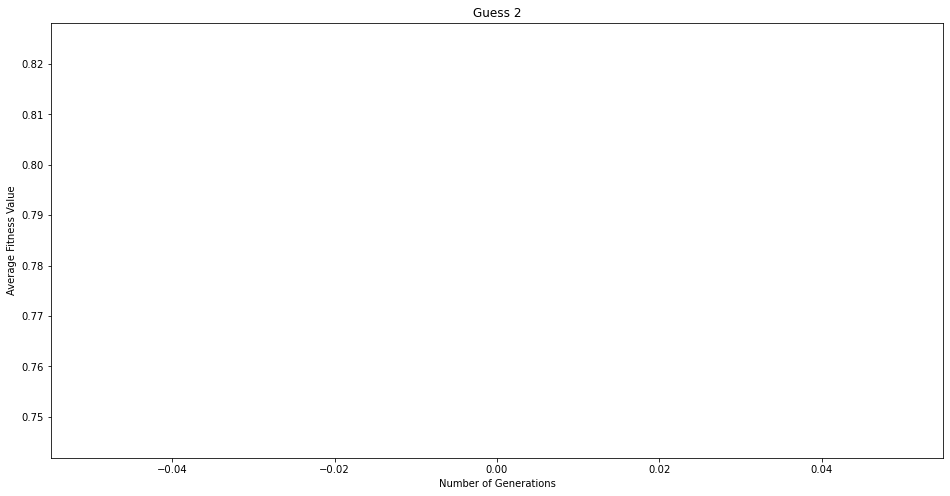

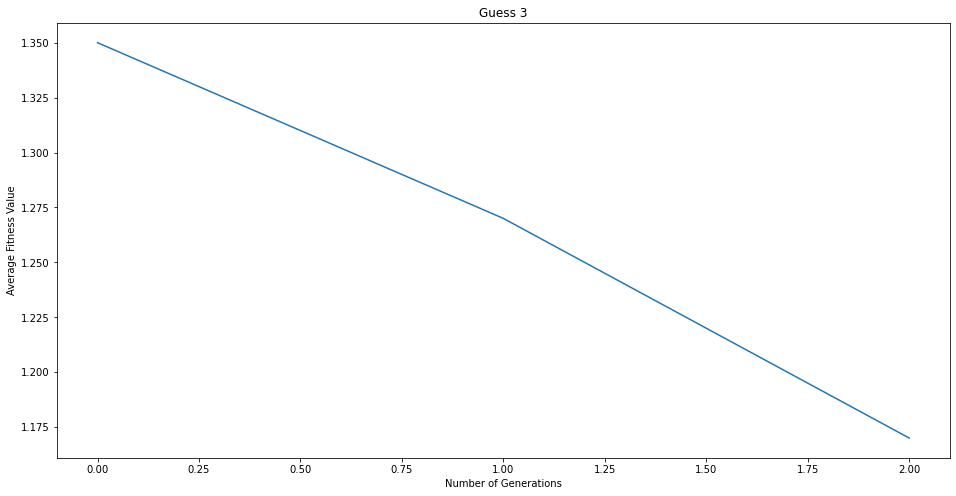

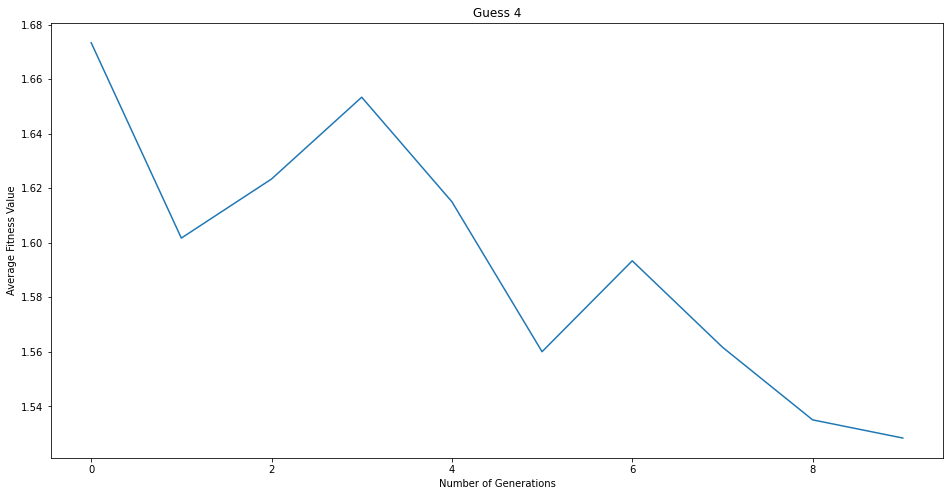

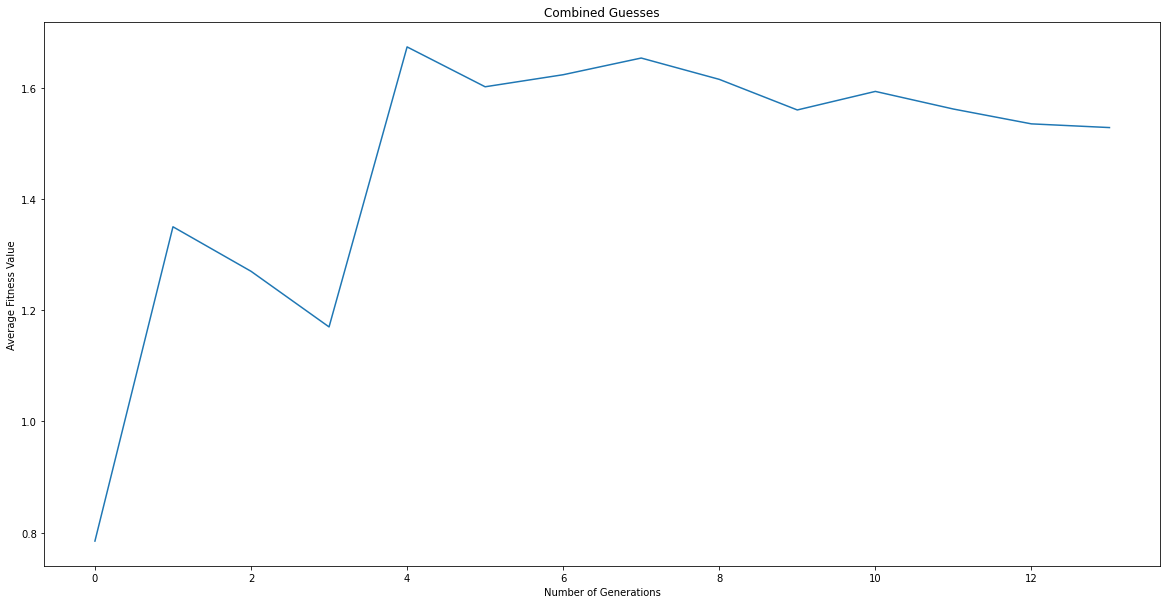

(4,
 0.2448272705078125,
 14,
 [[0.785],
  [1.35, 1.27, 1.17],
  [1.6733333333333338,
   1.6016666666666675,
   1.6233333333333326,
   1.6533333333333333,
   1.6149999999999998,
   1.5599999999999994,
   1.593333333333333,
   1.5616666666666656,
   1.5349999999999988,
   1.5283333333333327]])

In [374]:
import np, re, random, time
from collections import Counter
import matplotlib.pyplot as plt

def GA(
    SLOTS=3,
    N = 9,
    SELECTION = 0, # Tournament Selection
    UNIFORM_CROSSOVER_PROBABILITY = 0.5,
    SINGLESTART_CROSSOVER_PROBABILITY = 0,
    SINGLEEND_CROSSOVER_PROBABILITY = 0,
    DOUBLE_CROSSOVER_PROBABILITY = 1,
    BITFLIP_PROBABILITY = 0.03,
    PERMUTE_PROBABILITY = 0.03,
    SCRAMBLE_PROBABILITY = 0.03,
    INVERT_PROBABILITY = 0.03,
    NUM_PARENTS = 20,
    MAX_GENERATIONS = 50,
    POPSIZE = 100,
    ELITISM_RATE = 30,
    MAX_GUESS = 20,
    MAX_ELITES = 10,
    a = 1,
    b = 1,
    show_printout=True
):
    """
    Definitions:
    :param SLOTS: A Constant Value depicting P, the number of slots/pegs in the set-up
    :param N: The number of colours - 1
    :param SELECTION: If 0, K-Tournament Selection, Else Roulette Wheel Selection
    :param UNIFORM_CROSSOVER_PROBABILITY: mostly kept constant, probability of any one parent allele being chosen per gene
    :params SINGLESTART_CROSSOVER_PROBABILITY SINGLEEND_CROSSOVER_PROBABILITY: The probability of Single-Point Crossover of any one form taking place
    :param DOUBLE_CROSSOVER_PROBABILITY: The probability of Double-Point Crossover taking place
    :param BITFLIP_PROBABILITY: The probability of random changes in a speciific allele taking place
    :param PERMUTE_PROBABILITY: The probability of two alleles being swapped within a chromosome
    :param SCRAMBLE_PROBABILITY: The probability of a subsequence of alleles along a range of genes being scrambled
    :param INVERT_PROBABILITY: The probability of a subsequence of alleles along a range of genes being inverted
    :param NUM_PARENTS: Number of parents taken during Selection (either through K-Tournament Selection or Roulette Wheel Selection)
    :param MAX_GENERATIONS: Maximum number of Generations a guess can take to decide on a final chromosome to submit
    :param POPSIZE: Size of Parents' Group / Children's Group as randomly initialised
    :param ELITISM_RATE: If 0, Elitism does not take place, else the number of parents taken into the new children population
    :param MAX_GUESS: Bound to ensure that no unsatisfactory number of guesses take place
    :param MAX_ELITES: Bound to quantify size of Ei before Generations can end
    :param a: Coefficient of Magnitude of Difference between number of Bs based on a code c vs the number of Bs based on the secret code
    :param b: Coefficient of Magnitude of Difference between number of Ws based on a code c vs the number of Ws based on the secret code
    :param show_printout: Whether or not to display printout.
    """
    
    if show_printout:
        print("ELECTRONIC MASTERMIND 1977 Genetic Algorithm Solver")
        print("You have selected", SLOTS, "pegs.")
        print("Population Size:",POPSIZE, end="\t")
        print("Number of Parents:", n_parents, end="\t")
        print("Max Generations:", MAX_GENERATIONS)
        print("Elitism:", bool(ELITISM_RATE), end="\t")
        print("Elitism Rate:", ELITISM_RATE/POPSIZE, end="\t")
        print("Max Size of Ei:", MAX_ELITES)
        print("Bit-Flip Rate:", BITFLIP_PROBABILITY, end="\t")
        print("Permuation Rate:", PERMUTE_PROBABILITY, end="\t")
        print("Scrambling Rate:", SCRAMBLE_PROBABILITY, end="\t")
        print("Inversion Rate:", INVERT_PROBABILITY)
        print("Uniform Crossover Rate:", UNIFORM_CROSSOVER_PROBABILITY, end="\t")
        print("Single Point Crossover Rate:", SINGLESTART_CROSSOVER_PROBABILITY, SINGLEEND_CROSSOVER_PROBABILITY)
        print("Selection:","Roulette Wheel Selection" if SELECTION else "K-Tournament Selection")

    # Generates Probability Value (i.e output o is between 0 and 1)
    p = random.random

    # Generates Mastermind Values in Array of size :param *size:
    def rand(*size): return np.random.randint(N+1, size=size if len(size) else 1)


    # Abstract Code Class
    class Code(list):
        def __init__(self, *args):
            if len(args) == 1: args = args[0] # If you pass in an iterable, it is supposed to be able to read it too.
            super().__init__(map(int, args)) # Converting to int ensures no Data Type issues

        @classmethod
        def randomize(cls, slots=3):
            return cls(rand(slots)) # Class Method to generation a random Code based on the :param slots:

        def __repr__(self):
            return f"Code("+super().__repr__()[1:-1]+")" # Just a simple String Representation for Printing
        
        def __eq__(self, other):
            return hash(self) == hash(other) # Easy Equivalence Function

        def stringify(self):
            return "".join(map(str, self)) # Stringify joins all values into a single string

        def __hash__(self):
            return hash(self.stringify()) # Hashing Function for Sets
        
        def mark(self, secret):
            """
            Marking Function as required by the Game
            :param self: Guess to be Marked
            :param secret: Secret Code to Mark the Guess
            
            :returns tuple containing:
               - (Number of Bs, Number of Ws) in another tuple
               - ["."|"W"|"B"] array of size len(self) containing the marked script
            """
            output = ["." for i in range(SLOTS)] # original output
            bcount = wcount = 0
            for i in range(len(self)):
                if self[i] == secret[i]:
                    output[i] = "B" # B depict correct gene and correct allele equivalence
                    bcount += 1 # To maintain count (for speed)
            
            # A bit difficult to explain
            # Basicially, you have the two codes, but all with genes not matching to alleles (i.e. no Bs)
            # From here, you run a Counter to see how many of each allele there is
            # The `&` operator allows us to see an intersection, highlighting the number of Ws of each type of allele
            intersection = Counter([secret[i] for i in range(SLOTS) if output[i] != "B"]) & Counter([self[i] for i in range(SLOTS) if output[i] != "B"])

            for i in range(len(self)):
                if output[i] == "B": continue # Again, another precautionary measure
                if self[i] in intersection and intersection[self[i]] > 0: # Condition 1 is to see if the value even exists in secret, the second is to ensure this has not been previously used up
                    output[i] = "W" # W depicts Gene and Allele not matching (i.e. a swap can fix it)
                    wcount += 1 # To maintain count (for speed)
                    intersection[self[i]] -= 1 # This occurrence of the allele has been identified and used, hence we can discard it.

            return (bcount, wcount), output
        
        def fitness(self, guesses):
            sum = 0 # Iniial Sum is 0
            for (guess, guess_result) in guesses:
                B, W = guess.mark(self)[0] # As per above, B, W = (Number of Bs, Number of Ws)
                
                # a functions as the coefficient of the magnitude difference between the Bs predicted and Bs in actuality
                # b functions as the coefficient of the magnitude difference between the Ws predicted and Ws in actuality
                sum += a*abs(B - guess_result[0]) + b*abs(W - guess_result[1])
            
            # Take a mean
            return sum/len(guesses)


    class Chromosome(Code):
        def __init__(self, *args):
            super().__init__(*args) # Unnecessary constructor
            
        
        ## Crossover Methods
            
        def uniform_crossover(self, other, puniformcross=UNIFORM_CROSSOVER_PROBABILITY):
            """
            Method to perform Uniform Crossover over two iterables.

            Each gene is selected randomly from one of the corresponding genes of the parent chromosomes.
            Note: The crossover between two good solutions may not always yield a better or as good a solution.

            :params self other: The Parents
            :param puniformcross: The Probability of taking the second parent
            """
            return [self[i] if p() > puniformcross else other[i] for i in range(SLOTS)]
            
        def double_crossover(self, other, pdoublecross=DOUBLE_CROSSOVER_PROBABILITY):
            """
            Method to perform Two-Point Crossover over two iterables.
            
            Two random points are chosen on the individual chromosomes.
            The genetic material is exchanged at these points.
            
            :params self other: The Parents
            :param pdoublecross: The Probability of Two-Point Crossover taking place
            """
            code = self.copy()
            if p() < pdoublecross:
                a, b = sorted(np.random.choice(SLOTS, size=2, replace=False))
                code[a:b] = other[a:b]
            return code
            
        def single_start_crossover(self, other, psinglestartcross=SINGLESTART_CROSSOVER_PROBABILITY):
            """
            Method to perform Single-Point (Swap from Start) Crossover over two iterables.
            
            A crossover point on the parent chromosome is selected.
            All data beyond that point in the chromosome is swapped between the two parents.
            We take the chromosme where
             - before the point, the genetic markup resembles the first parent
             - beyond the point, the genetic markup resembles the second parent
            
            :params self other: The Parents
            :param psinglestartcross: The Probability of Single-Start-Point Crossover taking place
            """
            code = self.copy()
            if p() < psinglestartcross:
                pos = random.randint(0, SLOTS-1)
                self[pos:] = other[pos:]
            return code
            
        def single_end_crossover(self, other, psingleendcross=SINGLEEND_CROSSOVER_PROBABILITY):
            """
            Method to perform Single-Point (Swap from End) Crossover over two iterables.
            
            A crossover point on the parent chromosome is selected.
            All data beyond that point in the chromosome is swapped between the two parents.
            We take the chromosme where
             - before the point, the genetic markup resembles the second parent
             - beyond the point, the genetic markup resembles the first parent
            
            :params self other: The Parents
            :param psingleendcross: The Probability of Single-End-Point Crossover taking place
            """
            code = self.copy()
            if p() < psingleendcross:
                pos = random.randint(0, SLOTS-1)
                self[:pos] = other[:pos]
            return code
        
        def cross(self, other, puniformcross=UNIFORM_CROSSOVER_PROBABILITY, pdoublecross=DOUBLE_CROSSOVER_PROBABILITY, psinglestartcross=SINGLESTART_CROSSOVER_PROBABILITY, psingleendcross=SINGLEEND_CROSSOVER_PROBABILITY):
            """
            Method to perform all the aforementioned crossover methods based on the given probabilities.
            """
            uni = Chromosome.uniform_crossover(self, other, puniformcross)
            double = Chromosome.double_crossover(uni, other, pdoublecross)
            singlestart = Chromosome.single_start_crossover(double, other, psinglestartcross)
            singleend = Chromosome.single_end_crossover(singlestart, other, psingleendcross)
            return singleend
        
        ## Mutation Methods
        
        def bitflip(self, pbitflip=BITFLIP_PROBABILITY):
            """
            Method to perform "Bit Flip" Random Mutation over an iterable.
            
            We randomly select a specific gene, and randomise a new allele for the specific gene.
            
            :param self: The Parent
            :param pbitflip: The Probability of Random Mutation taking place
            """
            code = self.copy()
            if p() < pbitflip:
                code[random.randint(0, SLOTS-1)] = rand()
            return code
        
        def invert(self, pinvert=INVERT_PROBABILITY):
            """
            Method to perform Inversion Mutation over an iterable.
            
            We randomly select two specific genes on the chromosome.
            We then invert that subsequence of alleles to produce a slightly different chromsome.
            
            :param self: The Parent
            :param pinvert: The Probability of Inversion Mutation taking place
            """
            code = self.copy()
            if p() < pinvert:
                a, b = sorted(np.random.choice(SLOTS, size=2, replace=False))
                code =  code[:a]+code[b:a:-1]+code[b:]
            return code
        
        def scramble(self, pscramble=SCRAMBLE_PROBABILITY):
            """
            Method to perform Scrambling Mutation over an iterable.
            
            We randomly select two specific genes on the chromosome.
            We then scramble that subsequence of alleles to produce a slightly different chromsome.
            
            :param self: The Parent
            :param pinvert: The Probability of Scrambling Mutation taking place
            """
            code = self.copy()
            if p() < pscramble:
                a, b = sorted(np.random.choice(SLOTS, size=2, replace=False))
                code[a:b] = np.random.permutation(code[a:b])
            return code
        
        def permute(self, ppermute=PERMUTE_PROBABILITY):
            """
            Method to perform Permutation over an iterable.
            
            We randomly select two specific genes on the chromosome.
            We then swap the specific alleles for each of the genes within the chromsome.
            
            :param self: The Parent
            :param pinvert: The Probability of Permutation taking place
            """
            out = self.copy()
            if p() < ppermute:
                a, b = sorted(np.random.choice(SLOTS, size=2, replace=False))
                out[a], out[b] = out[b], out[a]
            return out
            
        def mutate(self, pbitflip=BITFLIP_PROBABILITY, pinvert=INVERT_PROBABILITY, pscramble=SCRAMBLE_PROBABILITY, ppermute=PERMUTE_PROBABILITY):
            """
            Method to perform all the aforementioned mutation methods based on the given probabilities.
            """
            flips = Chromosome.bitflip(self, pbitflip)
            inverts = Chromosome.invert(flips, pinvert)
            scrambled = Chromosome.scramble(inverts, pscramble)
            return Chromosome.permute(scrambled, ppermute)
        

    class Genotype(list):
        def __init__(self, size, slots, initial=[], guesses_list=None):
            if guesses_list is None: # Since Global Values are very bad
                guesses_list = guesses
                
            self.slots = slots # Kind of Unnecessary, could just fill in as SLOTS
            pop = set(initial) # Set works due to the defined __hash__ method
            while len(pop) < size: # In case distinct values are not created...
                # Set Union...
                pop |= {Chromosome([random.randint(0,9) for i in range(slots)]) for i in range(size-len(pop))}
            
            # Get Fitness Values for each Chromosome
            self.values = [(i, i.fitness(guesses_list)) for i in pop]
            # Sort based on Fitness (least fitness better)
            self.values.sort(key=lambda a:a[1])
            # Fixes it up as a list
            super().__init__([i[0] for i in self.values])
            # Get the fitness values...
            self.fitnesses = [i[1] for i in self.values]
        
        def parents(self, n_parents=NUM_PARENTS, selection=SELECTION):
            """
            Method to Get a set of Parents of size :param n_parents:
            
            We select based on the form of selection (based on :param selection:)
            
            :param n_parents: Number of Parents retrieved
            :param selection: If 0, Tournament Selection, else if 1, Roulette Wheel Selection
            """
            
            if selection: # Roulette Wheel Selection
                # Modified Fitness Function by f(x) = e^{-x}.
                # n_parents is the number of parents selected from the random.choices function
                return random.choices(self, map(lambda x:np.exp(-x), self.fitnesses), k=n_parents)
            else: # K-Tournament Selection
                # Alread sorted, so we just need o slice the population
                return self[:n_parents]
        
        def eligibles(self):
            """
            Method to get Eligibles (i.e. fitness = 0).
            
            For speed, we do not filter, but instead remember that this array is sorted by fitness.
            Hence, we find the last index of 0 fitness, and simply take that as our upper bound for slicing
            """
            index = -1
            for f in self.fitnesses:
                if f > 0: break # stops when last index has been found
                index += 1 # increments until last index containing 0 as a fitness value
            
            return self[:index+1] # Slicing is Upper-Bound Exclusive, hence we add 1 to the upper bound.
            
        def breed(self, guesses, n_parents=NUM_PARENTS, elitism_rate=ELITISM_RATE, selection=SELECTION):
            """
            Method for Breeding
            
            Parents are selected based on :params n_parents selection:.
            Based on :param elitism_rate:, a certain set of children is taken from the pool of parents.
            The, the crossover and mutation functions are applies to give us the final set of chromsomes.
            This set is then reinitialised as a Genotype.
            
            :param guesses: List of Previous Guesses and Results
            :param n_parents: Number of Parents Selected for Breeding
            :elitism_rate: Discrete Elitism Rate
            :selection: Selection Method Applied to select parents
                - If 0, Tournament Selection, else if 1, Roulette Wheel Selection
            """
            parents_pool = self.parents(n_parents, selection)
            
            children = parents_pool[:elitism_rate]
            for i in range(len(self)-len(children)):
                a, b = np.random.choice(n_parents, size=2, replace=False)
                crossed = parents_pool[a].cross(parents_pool[b])
                mutated = Chromosome.mutate(crossed)
                children.append(Chromosome(mutated))
            
            return Genotype(len(self), self.slots, initial=children, guesses_list=guesses) #, sum([i[1] for i in self.fitnesses])/150


    # Secret Code Randomly Selected
    code = Code.randomize(SLOTS)
    # Initial Guess: Code(0,1,2), Code(0,1,2,3) or Code(0,1,2,3,4) based on SLOTS
    init = Code(range(SLOTS))
    # Mark Initial Guess using Code
    score, marked = init.mark(code)
    
    if show_printout:
        print("The Code is", *code)
        print("Guess 1:", *init)
        print(*score, marked)
    
    # Guesses Array
    guesses = [(init, score)]
    # Guessed Codes
    guessed_codes = [init]
    # Guess Counter
    cnt = 2
    # Stored Array of Average Scores
    stored = []
    # Average Scores to be Returned
    avg_scores = []
    # Global Start Time of GA
    start = time.time()
    # While loop conditions ensure not too many guessses are taken, but also stops if you win.
    while cnt <= MAX_GUESS and guesses[-1][-1][0] != SLOTS:
        stored_i = len(stored) # startinng index of new data
        start_guess = time.time() # start of guess time
        pop = Genotype(POPSIZE, SLOTS, guesses_list=guesses) # Random Genotype Initialised
        Ei = set()  # Scope set of ELigibles
        gens = 1 # Generations Counter
        
        # While loop conditions ensure not too many generations take place, but also stops if Ei is long enough
        while gens <= MAX_GENERATIONS and len(Ei) < MAX_ELITES:
            gen_time = time.time() # start of generation time
            children = pop.breed(guesses=guesses) # breed out a new set of children
            Ei = Ei.union(pop.eligibles(), children.eligibles()) # Add new set of eligibles
            avg_score = (sum(pop.fitnesses) + sum(children.fitnesses))/(2*POPSIZE) # Average score of parents and children (i.e. workshing class)
            pop = Genotype(POPSIZE, SLOTS, initial=Ei, guesses_list=guesses) # new population with Ei as an intitial array
            
            stored.append(avg_score) # add generation-based average_score
            if show_printout: 
                print("#GEN", gens, ":", avg_score)
                print("Elapsed Time of Generation", time.time()-gen_time) # show the elapsed time of generation
            
            gens += 1 # increment generations

        if not len(Ei): continue # if Ei is still zero even after these gens, we reinitialise a new population
            
        possibles = tuple(Ei - set(guessed_codes)) # remove all previously guessed codes, to avoid repeat guesses
        submission = possibles[int(p() * len(possibles))] # choose a random code
        if show_printout:
            print(f"Guess {cnt}:", *submission)
            print("Elapsed Time of Guess:", time.time()-start_guess) # show the elapsed time of guess


        score, marked = submission.mark(code) # mark guess using code
        if show_printout: print(score, marked)
        guesses.append((submission, score)) # append to guesses
        guessed_codes.append(submission)
        avg_scores.append(stored[stored_i:]) # average scores added
        cnt += 1 # increment guess count
    
    # show the total elapsed time
    elapsed_time = time.time() - start
    if show_printout:
        print("YOU WIN!")
        print("Time elapsed was:", elapsed_time)
        
        # Average Fitness Values based on Guess
        for i,f in enumerate(avg_scores):
            plt.figure(figsize=(16,8))
            plt.plot(f)
            plt.title(f"Guess {i+2}")
            plt.xlabel("Number of Generations")
            plt.ylabel("Average Fitness Value")
            plt.show()


        # Average Fitness Values plotted over all Generations
        plt.figure(figsize=(20,10))
        plt.plot(stored)
        plt.title(f"Combined Guesses")
        plt.xlabel("Number of Generations")
        plt.ylabel("Average Fitness Value")
        plt.show()
    
    return len(guesses), elapsed_time, len(stored), avg_scores
    

# Randomize of select number of SLOTS
SLOTS = random.randint(3,5)
GA(SLOTS=SLOTS)

## Task 3: Optimization

3. [Does the Performance of the GA degrade if more codes are use in the game?](#Does-the-Performance-of-the-GA-degrade-if-more-codes-are-use-in-the-game?)
4. [What is the average number of guesses needed to solve a 3, 4 or 5 Pegged Games](#What-is-the-average-number-of-guesses-needed-to-solve-a-3,-4-or-5-Pegged-Games)
5. [Does using elitism help to improve the performance of your GA?](#Does-using-elitism-help-to-improve-the-performance-of-your-GA?)

### Data Collection and Retrieval

In [280]:
data = {}
count = 0
for slots in [3,4,5]:
    for (single_cross, double_cross) in [(0, 0.5), (0.5, 0)]: # Double-Point Crossover or Single-Point Crossover
        for mutrate in [0.03, 0.1, 0.3]: # 
            for maxgen in [50, 100]: # max generations
                for popsize in [50, 100, 150]: # population sizes
                    for elitism in [0, 30]: # elitism or not
                        for selection in [0,1]:
                            for sims in range(3):
                                count += 1
                                print("Simulation", count)
                                print("Slots:", slots)
                                print("Double Crossover:", bool(double_cross))
                                print("Mutation Rate:", mutrate)
                                print("Max Generations:", maxgen)
                                print("Population Size:", popsize)
                                print("Elitism Rate:", elitism)
                                print("Selection Type:", "Roulette Wheel Selection" if selection else "K-Tournament Selection")
                                print("Count of This Config:", sims)
                                output = GA(
                                    SLOTS=slots,
                                    SINGLESTART_CROSSOVER_PROBABILITY = single_cross,
                                    SINGLEEND_CROSSOVER_PROBABILITY = single_cross,
                                    DOUBLE_CROSSOVER_PROBABILITY = double_cross,
                                    BITFLIP_PROBABILITY = mutrate,
                                    PERMUTE_PROBABILITY = mutrate,
                                    SCRAMBLE_PROBABILITY = mutrate,
                                    INVERT_PROBABILITY = mutrate,
                                    MAX_GENERATIONS = maxgen,
                                    POPSIZE = popsize,
                                    SELECTION = selection,
                                    show_printout=False
                                )
                                print("Number of Guesses Taken:", output[0])
                                print("Time Elapsed:", output[1])
                                print("Total Generations Taken:", output[2])
                                print("================================================================")
                                data[(slots, 2*double_cross, mutrate, maxgen, popsize, elitism, selection, sims)] = output


Simulation 1
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 1.0359611511230469
Total Generations Taken: 54
Simulation 2
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 3.6316077709198
Total Generations Taken: 154
Simulation 3
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 8
Time Elapsed: 4.514850854873657
Total Generations Taken: 227
Simulation 4
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config

Number of Guesses Taken: 6
Time Elapsed: 5.633803606033325
Total Generations Taken: 105
Simulation 26
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 13.83935284614563
Total Generations Taken: 208
Simulation 27
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 9.62439751625061
Total Generations Taken: 153
Simulation 28
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 2.8960912227630615
Total Generations Taken: 54
Simulation 29
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
P

Number of Guesses Taken: 6
Time Elapsed: 11.645142555236816
Total Generations Taken: 204
Simulation 51
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 4.565929651260376
Total Generations Taken: 104
Simulation 52
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 9.778484344482422
Total Generations Taken: 202
Simulation 53
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 2
Time Elapsed: 0.023378372192382812
Total Generations Taken: 1
Simulation 54
Slots: 3
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 

Number of Guesses Taken: 6
Time Elapsed: 2.7591726779937744
Total Generations Taken: 116
Simulation 75
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 2.889042615890503
Total Generations Taken: 153
Simulation 76
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 5.826018333435059
Total Generations Taken: 204
Simulation 77
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 1.7655589580535889
Total Generations Taken: 108
Simulation 78
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Populat

Number of Guesses Taken: 4
Time Elapsed: 4.247504711151123
Total Generations Taken: 101
Simulation 100
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 10.338701486587524
Total Generations Taken: 158
Simulation 101
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 4
Time Elapsed: 0.21703696250915527
Total Generations Taken: 5
Simulation 102
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 9.356829404830933
Total Generations Taken: 152
Simulation 103
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Pop

Number of Guesses Taken: 7
Time Elapsed: 20.706372499465942
Total Generations Taken: 402
Simulation 125
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 15.036648511886597
Total Generations Taken: 305
Simulation 126
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 14.66224193572998
Total Generations Taken: 308
Simulation 127
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 7.608490943908691
Total Generations Taken: 204
Simulation 128
Slots: 3
Double Crossover: True
Mutation Rate: 0.1
Max Generations:

Number of Guesses Taken: 6
Time Elapsed: 1.6611814498901367
Total Generations Taken: 113
Simulation 149
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 4
Time Elapsed: 0.888808012008667
Total Generations Taken: 80
Simulation 150
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 9
Time Elapsed: 4.925516843795776
Total Generations Taken: 318
Simulation 151
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 1.6516666412353516
Total Generations Taken: 126
Simulation 152
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Pop

Number of Guesses Taken: 6
Time Elapsed: 5.458057403564453
Total Generations Taken: 103
Simulation 174
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 4.6474504470825195
Total Generations Taken: 104
Simulation 175
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 5.616586923599243
Total Generations Taken: 151
Simulation 176
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 4.625719308853149
Total Generations Taken: 103
Simulation 177
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 

Number of Guesses Taken: 9
Time Elapsed: 17.099050045013428
Total Generations Taken: 606
Simulation 199
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 5.675903081893921
Total Generations Taken: 209
Simulation 200
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 8.140056848526001
Total Generations Taken: 306
Simulation 201
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 4.712738990783691
Total Generations Taken: 203
Simulation 202
Slots: 3
Double Crossover: True
Mutation Rate: 0.3
Max Generat

Number of Guesses Taken: 5
Time Elapsed: 1.1092467308044434
Total Generations Taken: 103
Simulation 223
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 1.4531404972076416
Total Generations Taken: 111
Simulation 224
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 0.8320560455322266
Total Generations Taken: 105
Simulation 225
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 0.6588497161865234
Total Generations Taken: 57
Simulation 226
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Gen

Number of Guesses Taken: 6
Time Elapsed: 5.069703578948975
Total Generations Taken: 152
Simulation 247
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 8
Time Elapsed: 8.738556623458862
Total Generations Taken: 253
Simulation 248
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 4.040744781494141
Total Generations Taken: 105
Simulation 249
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 9
Time Elapsed: 10.151962041854858
Total Generations Taken: 302
Simulation 250
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Ge

Number of Guesses Taken: 7
Time Elapsed: 8.968792915344238
Total Generations Taken: 404
Simulation 271
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 4
Time Elapsed: 1.352705955505371
Total Generations Taken: 104
Simulation 272
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 2.79459547996521
Total Generations Taken: 202
Simulation 273
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 5.610127687454224
Total Generations Taken: 304
Simulation 274
Slots: 3
Double Crossover: False
Mutation Rate: 0.03
Max G

Number of Guesses Taken: 6
Time Elapsed: 0.9054629802703857
Total Generations Taken: 107
Simulation 297
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 2
Time Elapsed: 0.016041278839111328
Total Generations Taken: 4
Simulation 298
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 4
Time Elapsed: 0.5788676738739014
Total Generations Taken: 102
Simulation 299
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 9
Time Elapsed: 2.648684024810791
Total Generations Taken: 268
Simulation 300
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations

Number of Guesses Taken: 4
Time Elapsed: 1.1026594638824463
Total Generations Taken: 52
Simulation 321
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 3.255279779434204
Total Generations Taken: 108
Simulation 322
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 2.3385329246520996
Total Generations Taken: 102
Simulation 323
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 4.550155401229858
Total Generations Taken: 161
Simulation 324
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generation

Number of Guesses Taken: 7
Time Elapsed: 6.819452524185181
Total Generations Taken: 407
Simulation 345
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 7.17378044128418
Total Generations Taken: 404
Simulation 346
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 3.884917736053467
Total Generations Taken: 212
Simulation 347
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 2
Time Elapsed: 0.8826291561126709
Total Generations Taken: 100
Simulation 348
Slots: 3
Double Crossover: False
Mutation Rate: 0.1
Max Generati

Number of Guesses Taken: 9
Time Elapsed: 3.3314270973205566
Total Generations Taken: 304
Simulation 370
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 1.537567377090454
Total Generations Taken: 158
Simulation 371
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 1.8867838382720947
Total Generations Taken: 152
Simulation 372
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 4
Time Elapsed: 0.6593008041381836
Total Generations Taken: 56
Simulation 373
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 5

Number of Guesses Taken: 4
Time Elapsed: 1.9290626049041748
Total Generations Taken: 53
Simulation 395
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 4.2255988121032715
Total Generations Taken: 111
Simulation 396
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 5.155451536178589
Total Generations Taken: 107
Simulation 397
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 3.6343512535095215
Total Generations Taken: 303
Simulation 398
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generation

Number of Guesses Taken: 5
Time Elapsed: 5.0016233921051025
Total Generations Taken: 207
Simulation 419
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 3
Time Elapsed: 0.15668010711669922
Total Generations Taken: 7
Simulation 420
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 7.783167839050293
Total Generations Taken: 302
Simulation 421
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 8.594360113143921
Total Generations Taken: 203
Simulation 422
Slots: 3
Double Crossover: False
Mutation Rate: 0.3
Max Generati

Number of Guesses Taken: 7
Time Elapsed: 2.8029768466949463
Total Generations Taken: 163
Simulation 443
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 4
Time Elapsed: 0.9636733531951904
Total Generations Taken: 76
Simulation 444
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 3.456559658050537
Total Generations Taken: 217
Simulation 445
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 9
Time Elapsed: 7.924035310745239
Total Generations Taken: 217
Simulation 446
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 

Number of Guesses Taken: 9
Time Elapsed: 14.525994539260864
Total Generations Taken: 255
Simulation 468
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 0.8800034523010254
Total Generations Taken: 25
Simulation 469
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 8
Time Elapsed: 6.2889955043792725
Total Generations Taken: 429
Simulation 470
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 5.076000690460205
Total Generations Taken: 321
Simulation 471
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generatio

Number of Guesses Taken: 6
Time Elapsed: 3.535861015319824
Total Generations Taken: 115
Simulation 492
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 0.7569091320037842
Total Generations Taken: 29
Simulation 493
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 4.633275270462036
Total Generations Taken: 106
Simulation 494
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 8.963476657867432
Total Generations Taken: 205
Simulation 495
Slots: 4
Double Crossover: True
Mutation Rate: 0.03
Max Generati

Number of Guesses Taken: 5
Time Elapsed: 2.1630778312683105
Total Generations Taken: 207
Simulation 516
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 2.2452733516693115
Total Generations Taken: 183
Simulation 517
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 2.0562264919281006
Total Generations Taken: 103
Simulation 518
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 4.520968914031982
Total Generations Taken: 169
Simulation 519
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 

Number of Guesses Taken: 5
Time Elapsed: 2.5976457595825195
Total Generations Taken: 82
Simulation 541
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 3.5870003700256348
Total Generations Taken: 318
Simulation 542
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 5.765502691268921
Total Generations Taken: 318
Simulation 543
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 6.328218698501587
Total Generations Taken: 312
Simulation 544
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 

Number of Guesses Taken: 6
Time Elapsed: 8.584712505340576
Total Generations Taken: 206
Simulation 566
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 19.659291744232178
Total Generations Taken: 405
Simulation 567
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 5.706445693969727
Total Generations Taken: 106
Simulation 568
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 15.619760036468506
Total Generations Taken: 313
Simulation 569
Slots: 4
Double Crossover: True
Mutation Rate: 0.1
Max Generations

Number of Guesses Taken: 5
Time Elapsed: 1.5514452457427979
Total Generations Taken: 55
Simulation 591
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 8
Time Elapsed: 7.707340955734253
Total Generations Taken: 253
Simulation 592
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 2.3575918674468994
Total Generations Taken: 77
Simulation 593
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 1.9531664848327637
Total Generations Taken: 59
Simulation 594
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Po

Number of Guesses Taken: 6
Time Elapsed: 1.9094648361206055
Total Generations Taken: 126
Simulation 616
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 1.3401148319244385
Total Generations Taken: 101
Simulation 617
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 6.480314254760742
Total Generations Taken: 422
Simulation 618
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 2.3513693809509277
Total Generations Taken: 132
Simulation 619
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100


Number of Guesses Taken: 6
Time Elapsed: 11.554505348205566
Total Generations Taken: 204
Simulation 640
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 8.061511278152466
Total Generations Taken: 115
Simulation 641
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 16.440971851348877
Total Generations Taken: 214
Simulation 642
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 15.84854793548584
Total Generations Taken: 216
Simulation 643
Slots: 4
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 10

Number of Guesses Taken: 7
Time Elapsed: 4.46968674659729
Total Generations Taken: 155
Simulation 664
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 5.073989629745483
Total Generations Taken: 111
Simulation 665
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 2.1811106204986572
Total Generations Taken: 105
Simulation 666
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 2.0433411598205566
Total Generations Taken: 102
Simulation 667
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations

Number of Guesses Taken: 6
Time Elapsed: 7.331409931182861
Total Generations Taken: 516
Simulation 689
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 3.1041159629821777
Total Generations Taken: 224
Simulation 690
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 3.114508628845215
Total Generations Taken: 216
Simulation 691
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 0.5625865459442139
Total Generations Taken: 49
Simulation 692
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generati

Number of Guesses Taken: 6
Time Elapsed: 7.320282697677612
Total Generations Taken: 120
Simulation 713
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 4
Time Elapsed: 3.9484968185424805
Total Generations Taken: 102
Simulation 714
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 2
Time Elapsed: 2.385657548904419
Total Generations Taken: 100
Simulation 715
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 6.315050363540649
Total Generations Taken: 203
Simulation 716
Slots: 4
Double Crossover: False
Mutation Rate: 0.03
Max Gener

Number of Guesses Taken: 6
Time Elapsed: 2.66629695892334
Total Generations Taken: 115
Simulation 737
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 1.6317546367645264
Total Generations Taken: 65
Simulation 738
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 8
Time Elapsed: 5.5114758014678955
Total Generations Taken: 175
Simulation 739
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 1.8940730094909668
Total Generations Taken: 76
Simulation 740
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 

Number of Guesses Taken: 7
Time Elapsed: 7.621316194534302
Total Generations Taken: 342
Simulation 761
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 5.6951282024383545
Total Generations Taken: 329
Simulation 762
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 2.6223223209381104
Total Generations Taken: 168
Simulation 763
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 1.7315442562103271
Total Generations Taken: 124
Simulation 764
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generation

Number of Guesses Taken: 7
Time Elapsed: 17.10389733314514
Total Generations Taken: 304
Simulation 785
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 11.949769973754883
Total Generations Taken: 207
Simulation 786
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 3
Time Elapsed: 0.26299571990966797
Total Generations Taken: 8
Simulation 787
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 16.829188108444214
Total Generations Taken: 304
Simulation 788
Slots: 4
Double Crossover: False
Mutation Rate: 0.1
Max Generati

Number of Guesses Taken: 7
Time Elapsed: 5.315845489501953
Total Generations Taken: 79
Simulation 809
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 11.124879360198975
Total Generations Taken: 202
Simulation 810
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 9.8939790725708
Total Generations Taken: 181
Simulation 811
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 4.124804258346558
Total Generations Taken: 125
Simulation 812
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50

Number of Guesses Taken: 7
Time Elapsed: 3.872756004333496
Total Generations Taken: 326
Simulation 834
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 5.358045339584351
Total Generations Taken: 496
Simulation 835
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 3.1899752616882324
Total Generations Taken: 310
Simulation 836
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 3.1934974193573
Total Generations Taken: 314
Simulation 837
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations

Number of Guesses Taken: 6
Time Elapsed: 17.20144033432007
Total Generations Taken: 209
Simulation 858
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 14.051960229873657
Total Generations Taken: 305
Simulation 859
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 3.6770546436309814
Total Generations Taken: 115
Simulation 860
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 3.308908700942993
Total Generations Taken: 105
Simulation 861
Slots: 4
Double Crossover: False
Mutation Rate: 0.3
Max Gener

Number of Guesses Taken: 5
Time Elapsed: 2.8657824993133545
Total Generations Taken: 136
Simulation 882
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 9
Time Elapsed: 15.141045808792114
Total Generations Taken: 403
Simulation 883
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 2.105285167694092
Total Generations Taken: 73
Simulation 884
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 3.4424195289611816
Total Generations Taken: 115
Simulation 885
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generati

Number of Guesses Taken: 7
Time Elapsed: 4.052758455276489
Total Generations Taken: 314
Simulation 906
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 4.696401596069336
Total Generations Taken: 347
Simulation 907
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 3.5280425548553467
Total Generations Taken: 258
Simulation 908
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 8.964124202728271
Total Generations Taken: 471
Simulation 909
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generatio

Number of Guesses Taken: 9
Time Elapsed: 29.516570806503296
Total Generations Taken: 704
Simulation 930
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 0
Selection Type: K-Tournament Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 5.862820625305176
Total Generations Taken: 139
Simulation 931
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 8
Time Elapsed: 15.353404521942139
Total Generations Taken: 316
Simulation 932
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 4.717402458190918
Total Generations Taken: 115
Simulation 933
Slots: 5
Double Crossover: True
Mutation Rate: 0.03
Max Gener

Number of Guesses Taken: 6
Time Elapsed: 2.823737382888794
Total Generations Taken: 107
Simulation 955
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 4.951094627380371
Total Generations Taken: 163
Simulation 956
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 6.588301181793213
Total Generations Taken: 215
Simulation 957
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 3.3497331142425537
Total Generations Taken: 116
Simulation 958
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generation

Number of Guesses Taken: 5
Time Elapsed: 2.916677713394165
Total Generations Taken: 138
Simulation 980
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 6.276219606399536
Total Generations Taken: 523
Simulation 981
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 9.495734453201294
Total Generations Taken: 778
Simulation 982
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 23.284751415252686
Total Generations Taken: 863
Simulation 983
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations:

Number of Guesses Taken: 6
Time Elapsed: 5.12545371055603
Total Generations Taken: 128
Simulation 1004
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 4.625723838806152
Total Generations Taken: 116
Simulation 1005
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 5
Time Elapsed: 3.7741000652313232
Total Generations Taken: 112
Simulation 1006
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 20.59858536720276
Total Generations Taken: 437
Simulation 1007
Slots: 5
Double Crossover: True
Mutation Rate: 0.1
Max Genera

Number of Guesses Taken: 6
Time Elapsed: 2.9857311248779297
Total Generations Taken: 111
Simulation 1028
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 2.771122932434082
Total Generations Taken: 111
Simulation 1029
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 9.099090337753296
Total Generations Taken: 292
Simulation 1030
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 4.717885494232178
Total Generations Taken: 170
Simulation 1031
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generati

Number of Guesses Taken: 4
Time Elapsed: 1.6180837154388428
Total Generations Taken: 166
Simulation 1052
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 12.881168365478516
Total Generations Taken: 877
Simulation 1053
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 31.853668689727783
Total Generations Taken: 1907
Simulation 1054
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 7.578001499176025
Total Generations Taken: 468
Simulation 1055
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Gener

Number of Guesses Taken: 7
Time Elapsed: 10.015902519226074
Total Generations Taken: 214
Simulation 1076
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 31.677825212478638
Total Generations Taken: 411
Simulation 1077
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 20.187079668045044
Total Generations Taken: 311
Simulation 1078
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 4
Time Elapsed: 0.6609799861907959
Total Generations Taken: 18
Simulation 1079
Slots: 5
Double Crossover: True
Mutation Rate: 0.3
Max Gen

Number of Guesses Taken: 7
Time Elapsed: 6.054224252700806
Total Generations Taken: 218
Simulation 1100
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 2.004667043685913
Total Generations Taken: 102
Simulation 1101
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 5.3608949184417725
Total Generations Taken: 199
Simulation 1102
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 3.8153939247131348
Total Generations Taken: 213
Simulation 1103
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max

Number of Guesses Taken: 7
Time Elapsed: 11.22584342956543
Total Generations Taken: 427
Simulation 1124
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 3.899064779281616
Total Generations Taken: 205
Simulation 1125
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 7.877417087554932
Total Generations Taken: 342
Simulation 1126
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 1.6470041275024414
Total Generations Taken: 83
Simulation 1127
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max G

Number of Guesses Taken: 7
Time Elapsed: 10.380717515945435
Total Generations Taken: 216
Simulation 1148
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 5
Time Elapsed: 0.5378756523132324
Total Generations Taken: 16
Simulation 1149
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 8
Time Elapsed: 11.830536842346191
Total Generations Taken: 250
Simulation 1150
Slots: 5
Double Crossover: False
Mutation Rate: 0.03
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 24.104687690734863
Total Generations Taken: 488
Simulation 1151
Slots: 5
Double Crossover: False
Mutation Rate: 0.03

Number of Guesses Taken: 6
Time Elapsed: 6.786590576171875
Total Generations Taken: 174
Simulation 1172
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 13.170391321182251
Total Generations Taken: 271
Simulation 1173
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 8
Time Elapsed: 7.168229103088379
Total Generations Taken: 124
Simulation 1174
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 6
Time Elapsed: 4.322146892547607
Total Generations Taken: 74
Simulation 1175
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Gener

Number of Guesses Taken: 5
Time Elapsed: 3.1631507873535156
Total Generations Taken: 217
Simulation 1196
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 26.168800354003906
Total Generations Taken: 1313
Simulation 1197
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 13.86030387878418
Total Generations Taken: 733
Simulation 1198
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 10.515866041183472
Total Generations Taken: 623
Simulation 1199
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max G

Number of Guesses Taken: 7
Time Elapsed: 14.33965802192688
Total Generations Taken: 225
Simulation 1220
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 8
Time Elapsed: 24.570723295211792
Total Generations Taken: 317
Simulation 1221
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 7
Time Elapsed: 28.911073923110962
Total Generations Taken: 325
Simulation 1222
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 17.724241971969604
Total Generations Taken: 224
Simulation 1223
Slots: 5
Double Crossover: False
Mutation Rate: 0.1
Max

Number of Guesses Taken: 7
Time Elapsed: 6.5747106075286865
Total Generations Taken: 156
Simulation 1244
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 6
Time Elapsed: 5.372542142868042
Total Generations Taken: 144
Simulation 1245
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 4.32132363319397
Total Generations Taken: 113
Simulation 1246
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 50
Population Size: 100
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 8
Time Elapsed: 11.260224342346191
Total Generations Taken: 228
Simulation 1247
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Gene

Number of Guesses Taken: 8
Time Elapsed: 50.55733299255371
Total Generations Taken: 2073
Simulation 1268
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 38.15118908882141
Total Generations Taken: 1709
Simulation 1269
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 21.489988327026367
Total Generations Taken: 1099
Simulation 1270
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 50
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 7
Time Elapsed: 13.913132190704346
Total Generations Taken: 639
Simulation 1271
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max 

Number of Guesses Taken: 5
Time Elapsed: 6.740857124328613
Total Generations Taken: 124
Simulation 1292
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 1
Number of Guesses Taken: 7
Time Elapsed: 10.867576360702515
Total Generations Taken: 121
Simulation 1293
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: Roulette Wheel Selection
Count of This Config: 2
Number of Guesses Taken: 6
Time Elapsed: 9.389688968658447
Total Generations Taken: 121
Simulation 1294
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Generations: 100
Population Size: 150
Elitism Rate: 30
Selection Type: K-Tournament Selection
Count of This Config: 0
Number of Guesses Taken: 5
Time Elapsed: 22.3349506855011
Total Generations Taken: 285
Simulation 1295
Slots: 5
Double Crossover: False
Mutation Rate: 0.3
Max Ge

In [355]:
df = pd.DataFrame(data).T.reset_index().rename(columns={"level_0":"slots","level_1":"is_doublecross","level_2":"mutation", "level_3":"maxgen", "level_4":"popsize", "level_5":"elitism", "level_6":"is_roulette","level_7":"sim", 0:"guesses", 1:"time", 2:"generations", 3:"fitnesses"})#.set_index(["slots","singlecross","doublecross","nparents","maxgen","popsize"])
df

,slots,is_doublecross,mutation,maxgen,popsize,elitism,is_roulette,sim,guesses,time,generations,fitnesses
0,3,1.0,0.03,50,50,0,0,0,5,1.035961,54,"[[0.63], [0.66], [0.7133333333333333, 0.523333..."
1,3,1.0,0.03,50,50,0,0,1,7,3.631608,154,"[[0.72], [0.51], [0.7133333333333333, 0.559999..."
2,3,1.0,0.03,50,50,0,0,2,8,4.514851,227,"[[1.01], [1.05, 0.905, 0.685], [1.296666666666..."
3,3,1.0,0.03,50,50,0,1,0,6,1.882381,112,"[[0.93], [0.995, 0.935], [0.9333333333333331, ..."
4,3,1.0,0.03,50,50,0,1,1,4,0.891075,53,"[[0.7], [0.79, 0.645], [0.7933333333333333, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,5,0.0,0.30,100,150,30,0,1,7,10.867576,121,"[[1.0633333333333332], [1.085], [1.03888888888..."
1292,5,0.0,0.30,100,150,30,0,2,6,9.389689,121,"[[1.9566666666666668], [2.555, 2.6133333333333..."
1293,5,0.0,0.30,100,150,30,1,0,5,22.334951,285,"[[1.71], [2.3966666666666665, 2.355, 2.375, 2...."
1294,5,0.0,0.30,100,150,30,1,1,6,9.557855,132,"[[1.3366666666666667], [1.39], [1.417777777777..."


Add Categorical Variables in Pandas.

In [356]:
df["selection"] = df["is_roulette"].apply(lambda selection: "Roulette Wheel Selection" if selection else "K-Tournament Selection")
df["crossover"] = df["is_doublecross"].apply(lambda cross: "Double" if cross else "Single")
df["mutate_level"] = df["mutation"].apply(lambda mut: "High" if mut == 0.3 else "Medium" if mut == 0.1 else "Low")
df

,slots,is_doublecross,mutation,maxgen,popsize,elitism,is_roulette,sim,guesses,time,generations,fitnesses,selection,crossover,mutate_level
0,3,1.0,0.03,50,50,0,0,0,5,1.035961,54,"[[0.63], [0.66], [0.7133333333333333, 0.523333...",K-Tournament Selection,Double,Low
1,3,1.0,0.03,50,50,0,0,1,7,3.631608,154,"[[0.72], [0.51], [0.7133333333333333, 0.559999...",K-Tournament Selection,Double,Low
2,3,1.0,0.03,50,50,0,0,2,8,4.514851,227,"[[1.01], [1.05, 0.905, 0.685], [1.296666666666...",K-Tournament Selection,Double,Low
3,3,1.0,0.03,50,50,0,1,0,6,1.882381,112,"[[0.93], [0.995, 0.935], [0.9333333333333331, ...",Roulette Wheel Selection,Double,Low
4,3,1.0,0.03,50,50,0,1,1,4,0.891075,53,"[[0.7], [0.79, 0.645], [0.7933333333333333, 0....",Roulette Wheel Selection,Double,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,5,0.0,0.30,100,150,30,0,1,7,10.867576,121,"[[1.0633333333333332], [1.085], [1.03888888888...",K-Tournament Selection,Single,High
1292,5,0.0,0.30,100,150,30,0,2,6,9.389689,121,"[[1.9566666666666668], [2.555, 2.6133333333333...",K-Tournament Selection,Single,High
1293,5,0.0,0.30,100,150,30,1,0,5,22.334951,285,"[[1.71], [2.3966666666666665, 2.355, 2.375, 2....",Roulette Wheel Selection,Single,High
1294,5,0.0,0.30,100,150,30,1,1,6,9.557855,132,"[[1.3366666666666667], [1.39], [1.417777777777...",Roulette Wheel Selection,Single,High


(For safety) Save to a File.

In [357]:
df.to_csv("data/sims.csv", index=False)

Load back Dataset.

In [375]:
df = pd.read_csv("data/sims.csv")
df

,slots,is_doublecross,mutation,maxgen,popsize,elitism,is_roulette,sim,guesses,time,generations,fitnesses,selection,crossover,mutate_level
0,3,1.0,0.03,50,50,0,0,0,5,1.035961,54,"[[0.63], [0.66], [0.7133333333333333, 0.523333...",K-Tournament Selection,Double,Low
1,3,1.0,0.03,50,50,0,0,1,7,3.631608,154,"[[0.72], [0.51], [0.7133333333333333, 0.559999...",K-Tournament Selection,Double,Low
2,3,1.0,0.03,50,50,0,0,2,8,4.514851,227,"[[1.01], [1.05, 0.905, 0.685], [1.296666666666...",K-Tournament Selection,Double,Low
3,3,1.0,0.03,50,50,0,1,0,6,1.882381,112,"[[0.93], [0.995, 0.935], [0.9333333333333331, ...",Roulette Wheel Selection,Double,Low
4,3,1.0,0.03,50,50,0,1,1,4,0.891075,53,"[[0.7], [0.79, 0.645], [0.7933333333333333, 0....",Roulette Wheel Selection,Double,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,5,0.0,0.30,100,150,30,0,1,7,10.867576,121,"[[1.0633333333333332], [1.085], [1.03888888888...",K-Tournament Selection,Single,High
1292,5,0.0,0.30,100,150,30,0,2,6,9.389689,121,"[[1.9566666666666668], [2.555, 2.6133333333333...",K-Tournament Selection,Single,High
1293,5,0.0,0.30,100,150,30,1,0,5,22.334951,285,"[[1.71], [2.3966666666666665, 2.355, 2.375, 2....",Roulette Wheel Selection,Single,High
1294,5,0.0,0.30,100,150,30,1,1,6,9.557855,132,"[[1.3366666666666667], [1.39], [1.417777777777...",Roulette Wheel Selection,Single,High


Code to Reverse-Engineer `data`.

In [376]:
data = df.set_index(["slots", "is_doublecross", "mutation", "maxgen", "popsize", "elitism", "is_roulette", "sim"]).rename(columns={"guesses":0, "time":1, "generations":2, "fitnesses":3})[[0,1,2,3]].T.to_dict("list")

In [377]:
df.describe()

,slots,is_doublecross,mutation,maxgen,popsize,elitism,is_roulette,sim,guesses,time,generations
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.00000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,4.000000,0.500000,0.143333,75.000000,100.000000,15.00000,0.500000,1.000000,6.143519,7.835984,261.278549
std,0.816812,0.500193,0.114451,25.009651,40.840588,15.00579,0.500193,0.816812,1.294868,9.319659,330.681195
min,3.000000,0.000000,0.030000,50.000000,50.000000,0.00000,0.000000,0.000000,2.000000,0.016041,1.000000
25%,3.000000,0.000000,0.030000,50.000000,50.000000,0.00000,0.000000,0.000000,5.000000,2.607557,106.000000
50%,4.000000,0.500000,0.100000,75.000000,100.000000,15.00000,0.500000,1.000000,6.000000,4.978967,197.000000
75%,5.000000,1.000000,0.300000,100.000000,150.000000,30.00000,1.000000,2.000000,7.000000,9.774994,304.000000
max,5.000000,1.000000,0.300000,100.000000,150.000000,30.00000,1.000000,2.000000,10.000000,111.003787,3985.000000


### Q1: Comparison of Selection, Crossover and Mutation Rates (TODO)

To compare these values, we have the following ranges:

Selection:
- K-Tournament Selection
- Roulette Wheel Selection

Cross-Over:
- Double-Point Crossover
- Single-Point Crossover

Mutation Level:
- High (Probability of `0.3`)
- Medium (Probability of `0.1`)
- Low (Probability of `0.03`)

### Q2: What would be an ideal crossover and mutation rate?
We compare to see these differences.

In [367]:
df.groupby(["mutate_level", "crossover"]).guesses.mean().unstack()

crossover,Double,Single
mutate_level,,
High,6.162037,6.175926
Low,6.055556,6.074074
Medium,6.175926,6.217593


In [368]:
df.groupby(["mutate_level", "crossover"]).time.mean().unstack()

crossover,Double,Single
mutate_level,,
High,7.808760,8.799400
Low,7.764945,6.094876
Medium,7.871560,8.676366


We have the following individual conclusions based on the above data:
- $min(n_{guesses})$ occurs at Double-Point Crossover and a Low Mutation Rate
- $min(t_{elapsed})$ occurs at Single-Point Crossover and a Low Mutation Rate

From here, we know that the Low Mutation Rate (Probability of `0.03`) is the ideal Mutation Rate.

We also note that in these levels, Single-Point Crossover is significantly faster than Double-Point Crossover, although in terms of guesses, there is not much of a difference at a Low Mutation Rate, hence **Single-Point Crossover** is preferred under a **Low Mutation Rate**, and these are ideal values.

### Does the Performance of the GA degrade if more codes are use in the game?

Text(0.5, 0.98, '$n_{guesses}$ Data Distribution Plots')

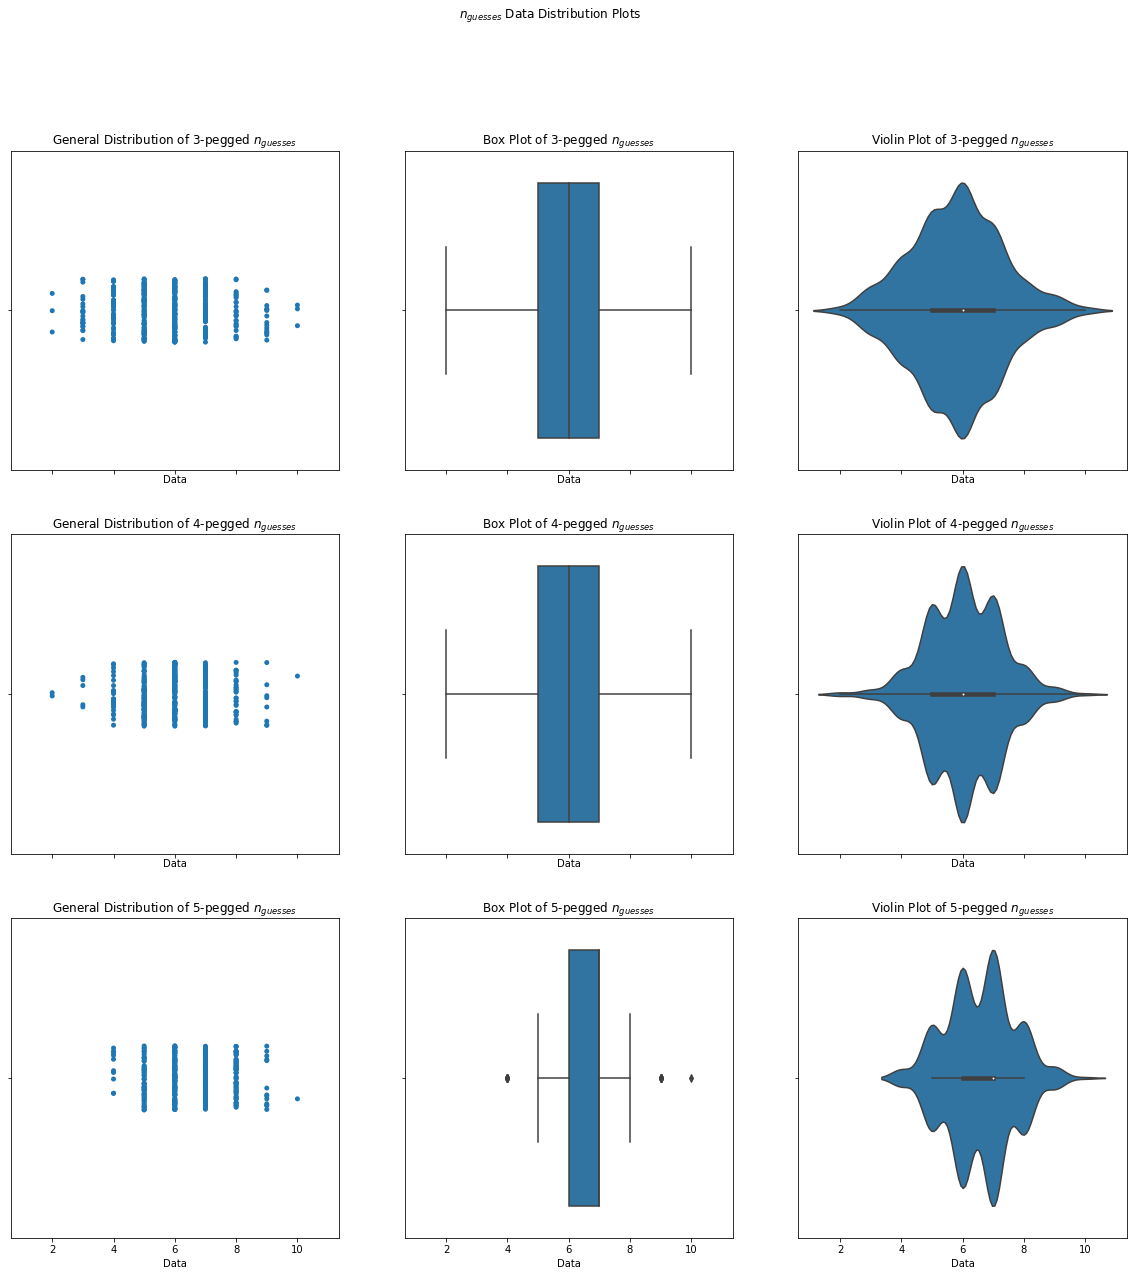

In [332]:
bySlot = df.set_index("slots")[["guesses", "time"]]
fig, axes = plt.subplots(3, 3,figsize=(20, 20), sharex=True)
for i in range(3):
    slots = i+3
    data = bySlot.loc[slots].guesses
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of "+str(slots)+"-pegged $n_{guesses}$")
    
fig.suptitle("$n_{guesses}$ Data Distribution Plots")

Text(0.5, 0.98, '$t_{elapsed}$ Data Distribution Plots')

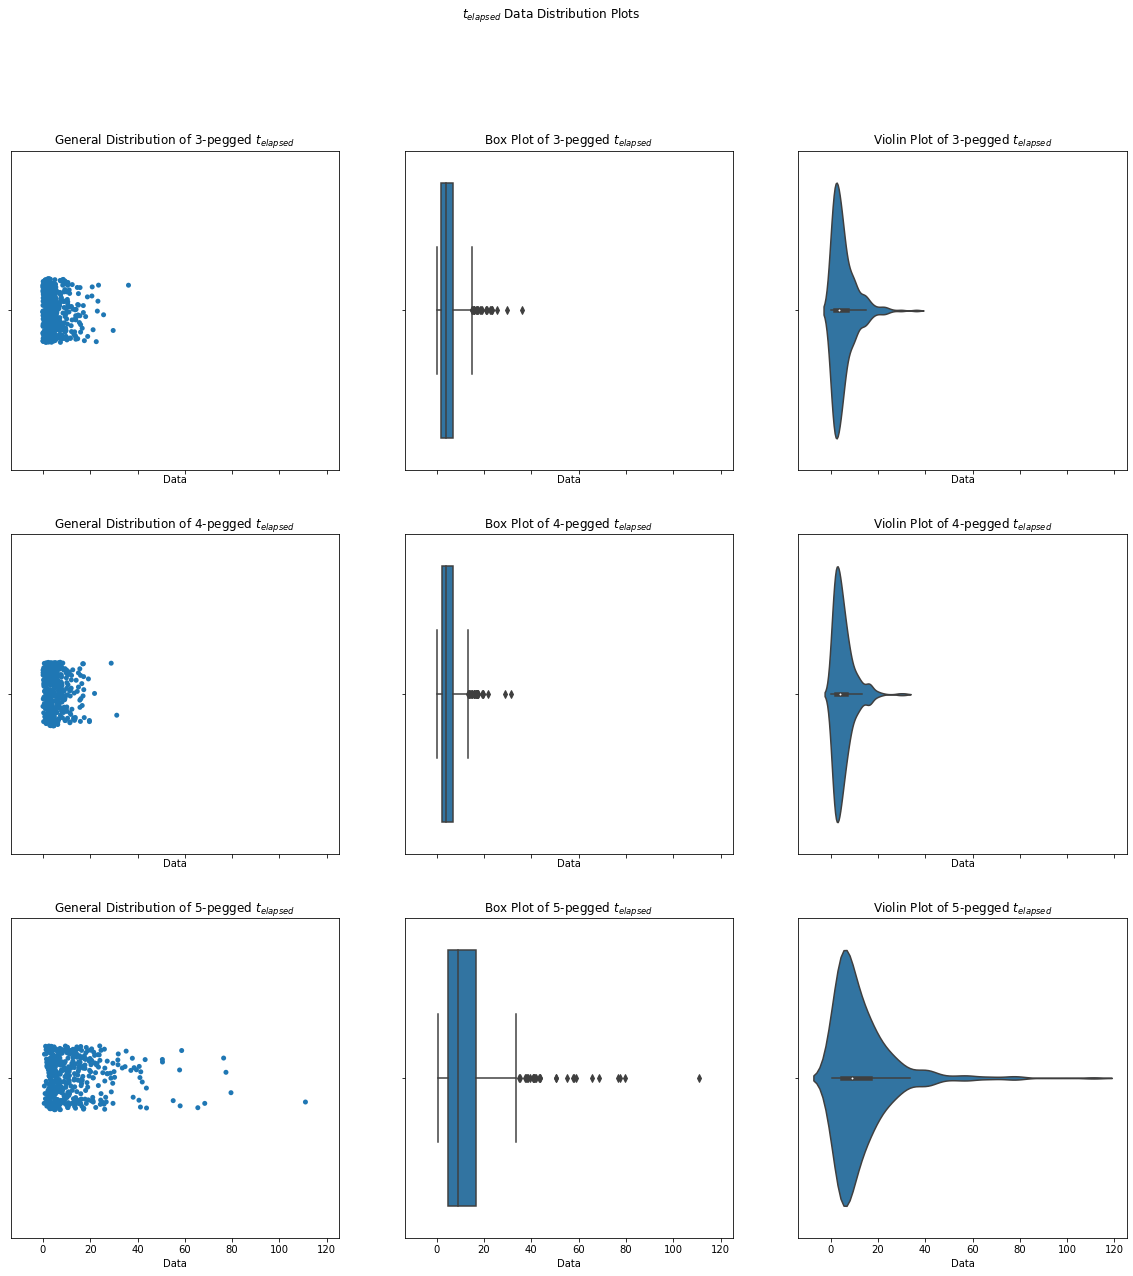

In [333]:
bySlot = df.set_index("slots")[["guesses", "time"]]
fig, axes = plt.subplots(3, 3,figsize=(20, 20), sharex=True)
for i in range(3):
    slots = i+3
    data = bySlot.loc[slots].time
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of "+str(slots)+"-pegged $t_{elapsed}$")
    
fig.suptitle("$t_{elapsed}$ Data Distribution Plots")

#### What is the average number of guesses needed to solve a 3, 4 or 5 Pegged Games
For this task, we simply apply a grouping function to see how guesses, on average, fares with regards to $n_{guesses}$.

In [380]:
df.groupby("slots")[["guesses"]].mean().reset_index()

,slots,guesses
0,3,5.807870
1,4,6.057870
2,5,6.564815


From here, we determine that the average number of guesses for the following cases as shown:
<div align="center">
<table>
<thead>
<tr>
<th>slots</th>
<th>guesses</th>
</tr>
</thead>
<tbody>
<tr>
<td>3</td>
<td>5.807870</td>
</tr>
<tr>
<td>4</td>
<td>6.057870</td>
</tr>
<tr>
<td>5</td>
<td>6.564815</td>
</tr>
</tbody>
</table>

</div>

Text(0.5, 0.98, '$n_{guesses}$ Data Distribution Plots')

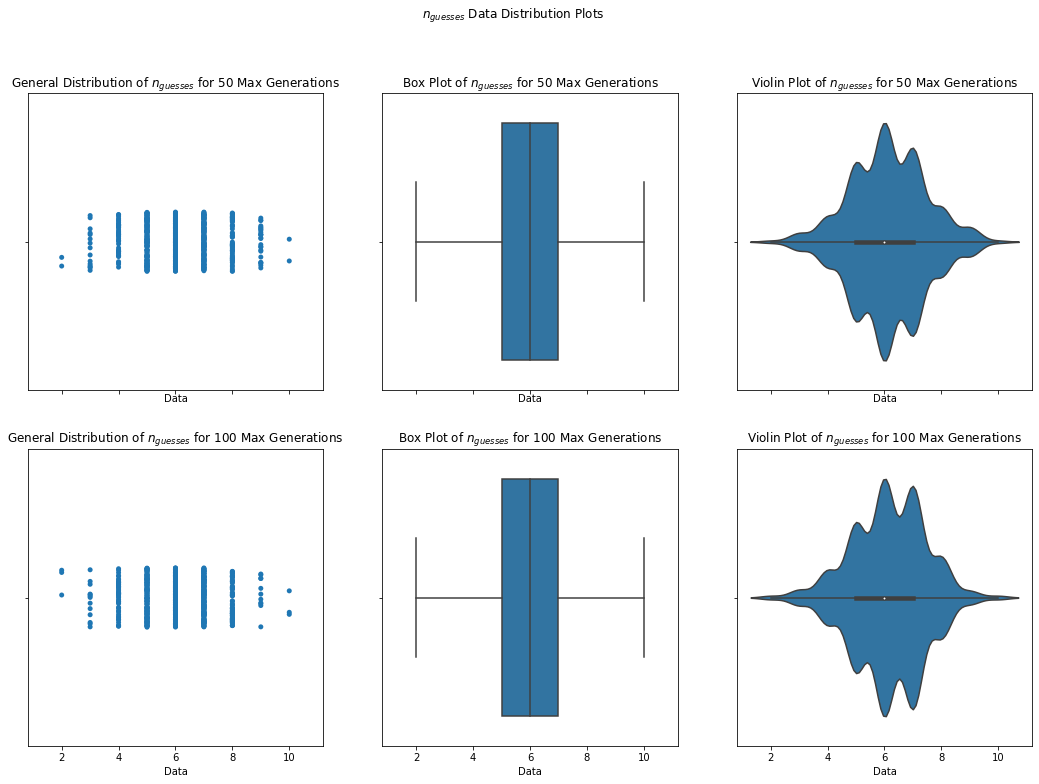

In [295]:
byMaxGen = df.set_index("maxgen")[["guesses", "time"]]
fig, axes = plt.subplots(2, 3,figsize=(18,12), sharex=True)
for i in range(2):
    maxgen = (i+1)*50
    data = byMaxGen.loc[maxgen].guesses
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of $n_{guesses}$ for "+str(maxgen)+" Max Generations")
    
fig.suptitle("$n_{guesses}$ Data Distribution Plots")

Text(0.5, 0.98, '$t_{elapsed}$ Data Distribution Plots')

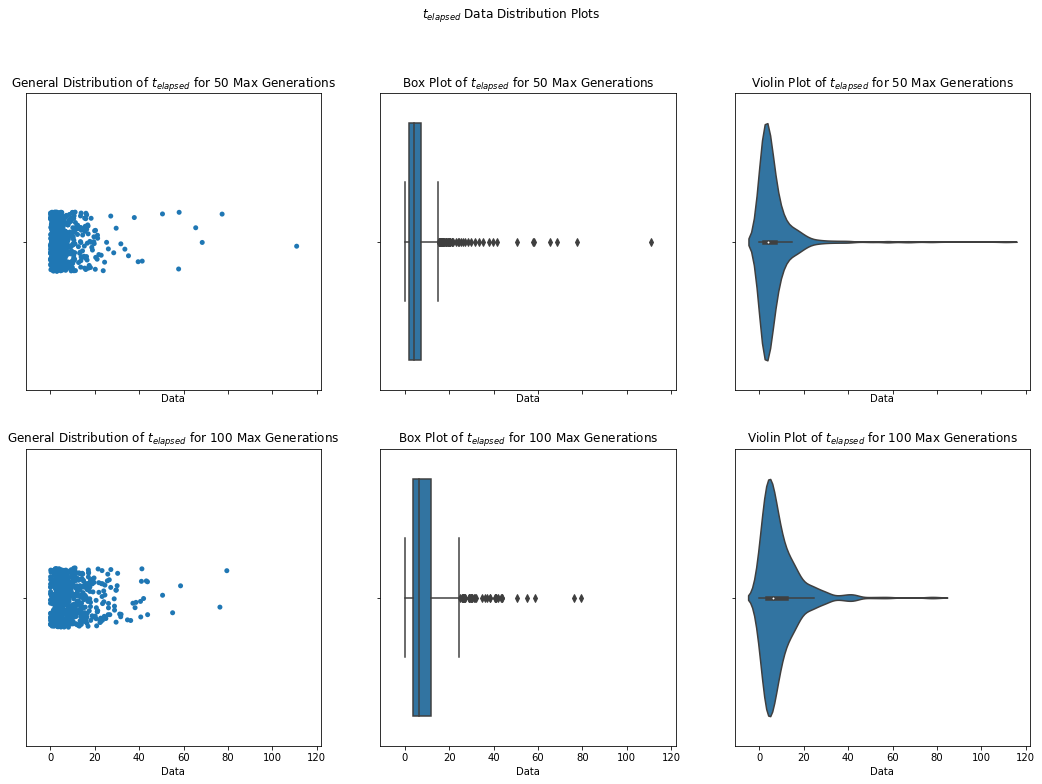

In [296]:
byMaxGen = df.set_index("maxgen")[["guesses", "time"]]
fig, axes = plt.subplots(2, 3,figsize=(18, 12), sharex=True)
for i in range(2):
    maxgen = (i+1)*50
    data = byMaxGen.loc[maxgen].time
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of $t_{elapsed}$ for "+str(maxgen)+" Max Generations")
    
fig.suptitle("$t_{elapsed}$ Data Distribution Plots")

In [297]:
df

,slots,doublecross,mutation,maxgen,popsize,elitism,is_roulette,sim,guesses,time,generations,fitnesses
0,3,1.0,0.03,50,50,0,0,0,5,1.035961,54,"[[0.63], [0.66], [0.7133333333333333, 0.523333..."
1,3,1.0,0.03,50,50,0,0,1,7,3.631608,154,"[[0.72], [0.51], [0.7133333333333333, 0.559999..."
2,3,1.0,0.03,50,50,0,0,2,8,4.514851,227,"[[1.01], [1.05, 0.905, 0.685], [1.296666666666..."
3,3,1.0,0.03,50,50,0,1,0,6,1.882381,112,"[[0.93], [0.995, 0.935], [0.9333333333333331, ..."
4,3,1.0,0.03,50,50,0,1,1,4,0.891075,53,"[[0.7], [0.79, 0.645], [0.7933333333333333, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,5,0.0,0.30,100,150,30,0,1,7,10.867576,121,"[[1.0633333333333332], [1.085], [1.03888888888..."
1292,5,0.0,0.30,100,150,30,0,2,6,9.389689,121,"[[1.9566666666666668], [2.555, 2.6133333333333..."
1293,5,0.0,0.30,100,150,30,1,0,5,22.334951,285,"[[1.71], [2.3966666666666665, 2.355, 2.375, 2...."
1294,5,0.0,0.30,100,150,30,1,1,6,9.557855,132,"[[1.3366666666666667], [1.39], [1.417777777777..."


### Does using elitism help to improve the performance of your GA?

In [338]:
df.groupby("elitism")["guesses", "time"].mean()

C:\Users\Prannaya\AppData\Local\Temp/ipykernel_24256/3887640259.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("elitism")["guesses", "time"].mean()


,guesses,time
elitism,,
0,6.182099,8.128213
30,6.104938,7.543756


Text(0.5, 0.98, '$n_{guesses}$ Data Distribution Plots')

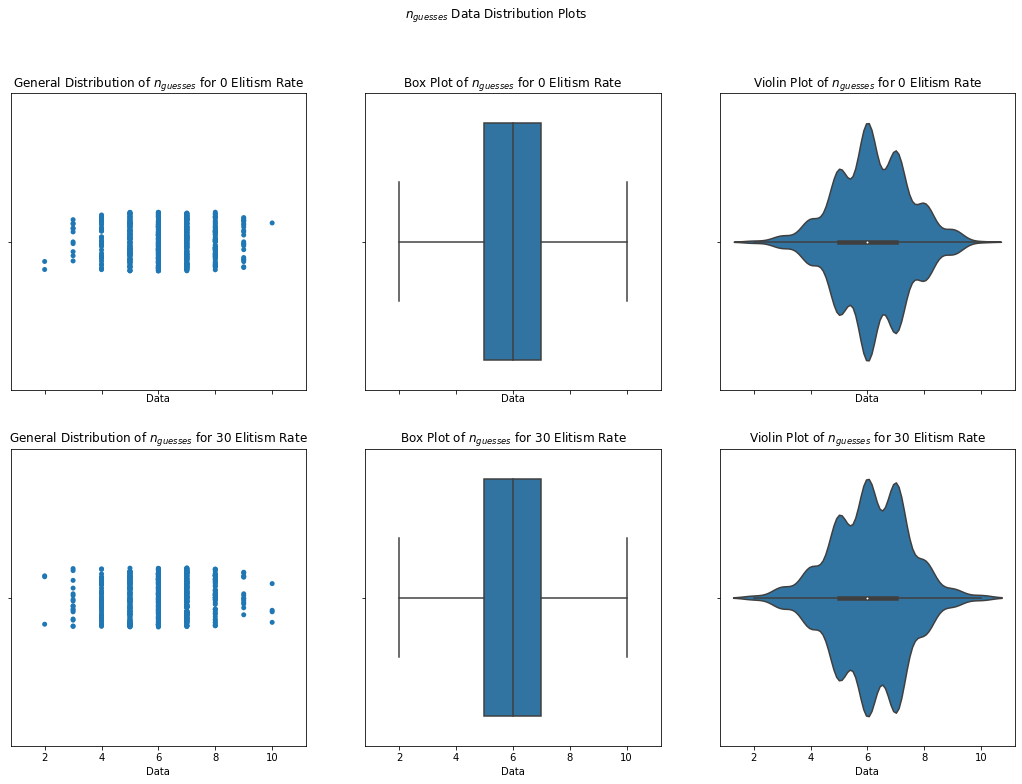

In [336]:
byElitism = df.set_index("elitism")[["guesses", "time"]]
fig, axes = plt.subplots(2, 3, figsize=(18,12), sharex=True)
for i in range(2):
    elitism = 30 * i
    data = byElitism.loc[elitism].guesses
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of $n_{guesses}$ for "+str(elitism)+" Elitism Rate")
    
fig.suptitle("$n_{guesses}$ Data Distribution Plots")

Text(0.5, 0.98, '$t_{elapsed}$ Data Distribution Plots')

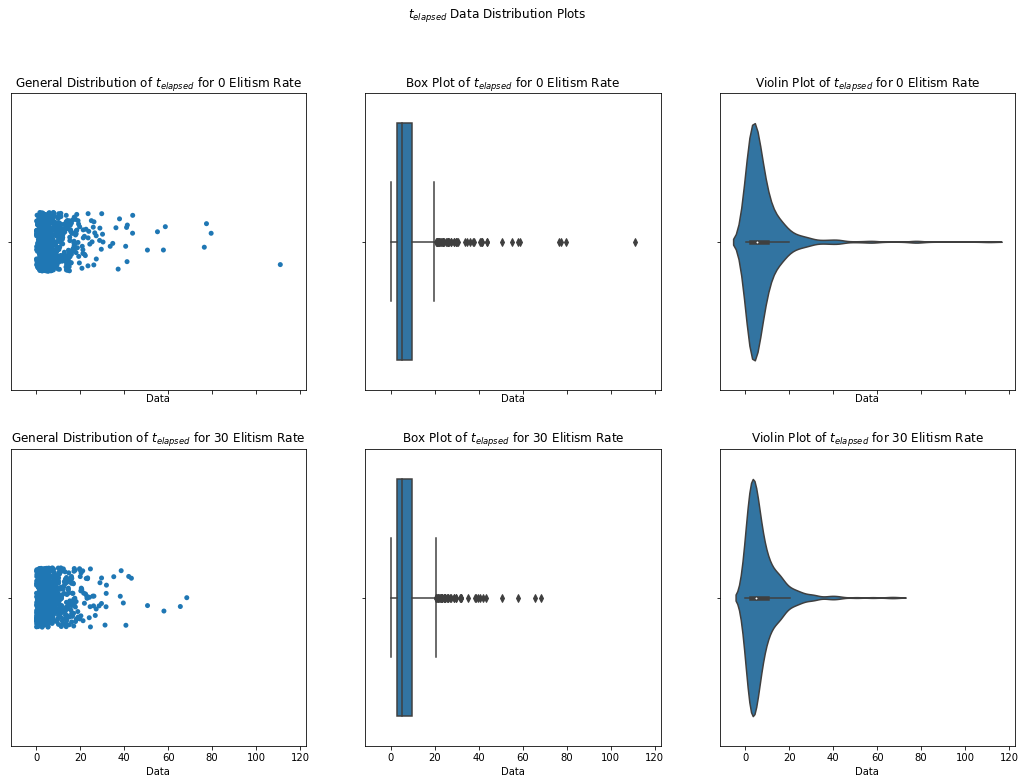

In [337]:
byElitism = df.set_index("elitism")[["guesses", "time"]]
fig, axes = plt.subplots(2, 3, figsize=(18,12), sharex=True)
for i in range(2):
    elitism = 30 * i
    data = byElitism.loc[elitism].time
    functions = [sns.stripplot, sns.boxplot, sns.violinplot]
    names = ["General Distribution", "Box Plot", "Violin Plot"]
    for j,func,name in zip(range(3), functions, names):
        ax = axes[i, j]
        func(x=data, ax=ax)
        ax.set(xlabel="Data", title=name+" of $t_{elapsed}$ for "+str(elitism)+" Elitism Rate")
    
fig.suptitle("$t_{elapsed}$ Data Distribution Plots")

By looking at the above graph, especially given the reduction of Range and Outlier Range, in addition to the relatively similar distributions of $n_{guesses}$, and of course the mean values of $n_{guesses}$ and $t_{elapsed}$, elitism slightly improves the performance of the Genetic Algorithm.